In [1]:
from typing import Dict, List, Union

import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib as mpl

In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

In [145]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

from keras.metrics import (TruePositives, FalsePositives, TrueNegatives, FalseNegatives, 
                           BinaryAccuracy, Precision, Recall, AUC)

In [4]:
pylab.rcParams['figure.figsize'] = 10, 10
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Summary

**First thoughts**

The task is to classify the bounding box from the input invoice to a text item or not. 

Each invoice has several bounding boxes of different sizes. Also, an invoice can contain more than one page.

Available data:
- length of the bounding box value
- relative location of the bounding box
- a sequence of bounding boxes per invoice

I would expect the text items: 
- are located on the left side of the page
- are located somewhere between below the headers and the bottom of the first page, but on the 2nd page they are located all over the page
- have a bigger bounding box than e.g. raw values; since items are more specified than e.g. the price
- that there is a sequence of bounding boxes on the same y-coordinates with [item, no item, no item], and so on. Indicating, the text and then the price, taxes, and so on.

This is only true for most german invoices. My experience lacks international invoices, but I assume, it will be the same for most of the countries using a Latin alphabet. 

**Steps**:

The data is imbalanced. Every invoice has at least one text item, but only 5% of the provided bounding boxes are text items (ignoring the invoice id structure). The chosen metric for the classification is the F1-Score, which is calculated by precision and recall.

I followed two approaches:

- Train a tree & ensemble on the data, which ignores the invoice id and the sequence of bounding boxes. This violates the structure of the data. This is my fallback solution, if I fail with my other approach. Also, I will see, how good a text classification can be generalized by the position on a page. Here I also try over- and undersampling of the data. Oversampling costs too much time in training and doesn't give any benefit in the F1-score. I discarded this approach.

- Training an LSTM, which takes the sequence of the bounding boxes into considerations, but still ignores the invoice ids. For me, it was unclear, if I can get to a running model and if, how well will it perform. Also, the training of my last LSTM is a while ago and for my current project of implementing deep learning models from scratch, LSTMs will be done next week. So I'm currently renewing my expertise. Also I introduce weights based on the amount of the labels in the data. My approach here has many short-comings, but in my overnight training, I got a model, which outperforms the XGBoost model. So I tried to add the code here, but there is somewhere an error.

**Results** on the test set are:

XGBoost:
- F1: 0.27
- Precision: 0.18
- Recall: 0.59

LSTM:
- F1: 0.23
- Precision: 0.13
- Recall: 0.85

The precision is in both models bad. There are too many False Positives, non-text items classified as text-items. 
One reason is, that the data is "noisy", as seen in the pair plots. More features could be an improvement. The recall is good, but there are too many False Positives in the prediction.

**Future steps** to improve the models is:

- feature engineering - I didn't spend much time here, but just counting elements in specific areas could be an improvement. One goal could be to get a classification of the type of invoice itself.. 

- invoice classification - there are different types of invoices, probably

- thinking in calm about the problem. It still can be, that I missed something very obvious. probably I messed up at feature engineering or data preparation. There are a lot more possibilities beyond the applied bbox volume.

- doing research; I'm definitely not the first, who works on this kind of sequential problem. There should be some papers, just to collect more ideas.

- model improvement: the LSTM needs definitely more time; probably longer sequences, more features. Since this is a very very early prototype, I'm surprised that the model won't predict only zeros (as most of my prototypes did). 

1) What is good measure for classification accuracy? 

- imbalanced data; F1-Score, AUC.
I will go for the  F1-Score, since a high precision or a high recall is not useful here, they just will end up in more manual work (cleaning) 

2) What are possible shortcomings and extensions of your implementation? 


- no proper cross-validation for the xgboost. Needs definetly a fix. I focused too much an model preparation for imbalanced data (under- and oversampling), prototyping different models than doing one thing right.
- adding regularization to avoid over-fitting
- A shortcoming is the low F1-score
- I didn't find a suitable model to represent the data structure for each invoice. The invoice id is neglected in both models and I need some research here. I guessed an LSTM will handle this kind of data, but my prototype wasn't convincing. For a tree approach, there should be more time spent in feature engineering, but my intuition says, that this is not enough. My LSTM is one whole shortcoming. It needs improvement in model architecture, data preparation (features and sequences), initialization, and so on.

- the values could give probably more information; e.g. if the item is a text or a number / nlp

- next step would be to revisit all my findings and my approaches. I put too much effort in different approaches than to think very deep about the problem. Normally the interesting ideas come, when the low-hanging fruits fail. :)

- train-test-val split in not stratified. this also has to be fixed. 
- no pipelines for the data preparation. This will hurt in production and is bad style. 

3) How would you design a real-time performance system that responds to a high volume of prediction requests efficiently.  

- I always deployed my models via flask, gunicorn, docker on k8s. This is normally scalable, but it always depends on the traffic volume. The model itself: I prefer small models with fewer preparation steps and a fast prediction. This normally hurts accuracy. For my examples, none of the models is production-ready by the metrics. If prediction time is the constraint, I would go for the XGboost.

### Data pipeline

Basically I take the json files and convert it into a csv file. 

I merge words and entitites by invoice id, page number and indices.

data is not cleaned.

The available raw data is split in words and entities. 
The words data includes the OCR detection of the text value and the according location of the bounding box on the page.
The entities data specifies the value of the words data. So it keeps the information, if the bounding box is an item or not. 

The helpers function is my repo

In [75]:
import helpers

In [6]:
files = ["hypatos-ds-train", "hypatos-ds-test"]

In [7]:
#todo: get rid of the hard-coded column names; introduce a config file 
for file in files:
    helpers.data_preparation_strategy(file)

As a first step, the json data had to be converted in a more suitable data format. Here I choose pandas to get a better idea and intuition of the data.

The task is to detect items from input invoice.


Each invoice has several bounding boxes of different size. Also an invoice can contain more than one page.
Available data:
- length of the bounding box value
- relative location of the bounding box
- sequence of bounding boxes per invoice

I would expect the items: 
- are listed on the left side of the page
- are listed somewhere between below the headers and the bottom of the first page; but from top and bottom on the 2nd page
- have a bigger bounding box than e.g. raw values; since items are more specified than the price
- that there is a sequence of bounding boxes on the same y-coordinates with [item, no item, no item] and so on. Indicating, the text and then the price, taxes and so on.

This is only true for most of german invoices. My experience lacks of international invoices, but I assume, it will be the same for most of the countries using a latin alphabet. 

Next steps:
- EDA to get more information about the data; can I already derive some rules from the data, based on my first thoughts

- I would setup a baseline model based on the eda or a decision tree. A decision tree ignores the structure of the invoice and only would look at each bounding box seperately. This still can work well, since most text information are well seperated on an invoice.

- If I have enough time, I would try a method, where I can use the sequence information on a page. I assume, a RNN, LSTM could work in this case. At least this needs some research from my side.

### Cleaning and preparation

In [8]:
def drop_columns(data, columns: List) -> pd.DataFrame:
    return data.drop(columns, axis=1)


def fill_nan(data: pd.DataFrame, value: Union[float, int]) -> pd.DataFrame:
    return data.fillna(value)


In [9]:
train = pd.read_csv("hypatos-ds-train.csv")
test = pd.read_csv("hypatos-ds-test.csv")

In [10]:
train.head()

,value,region.left,region.top,region.width,region.height,region.page,id,indices,label,metaData.region.page,n_idx_item
0,U1Raiug=,0.371253,0.020022,0.025749,0.015017,1,83132716,0,NaN,NaN,NaN
1,WC8whnZ1fnk=,0.345503,0.033092,0.224058,0.028087,1,83132716,1,NaN,NaN,NaN
2,Lg==,0.345503,0.050334,0.039201,0.017798,1,83132716,2,NaN,NaN,NaN
3,d354fYR1ew==,0.406995,0.062291,0.048040,0.005840,1,83132716,3,NaN,NaN,NaN
4,Vw==,0.463874,0.062291,0.007302,0.005562,1,83132716,4,NaN,NaN,NaN


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992072 entries, 0 to 5992071
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   value                 object 
 1   region.left           float64
 2   region.top            float64
 3   region.width          float64
 4   region.height         float64
 5   region.page           int64  
 6   id                    int64  
 7   indices               int64  
 8   label                 object 
 9   metaData.region.page  float64
 10  n_idx_item            float64
dtypes: float64(6), int64(3), object(2)
memory usage: 502.9+ MB


The metaData.region.page is identical with the region page, so it can also be dropped.
The n_idx_item is information I extracted from the entities data and counts the number of words in one entity dict. We won't have this information for the model training, so it also can be dropped.

In [12]:
columns = ["metaData.region.page", "n_idx_item"]

In [13]:
train = drop_columns(train, columns)
test = drop_columns(test, columns)

the label feature has two value, item and None. So this will be our classifier.


In [14]:
train = fill_nan(train, 0)
test = fill_nan(test, 0)

In [15]:
train.label.replace("item", 1, inplace=True)
test.label.replace("item", 1, inplace=True)

## EDA

We have around 6 million bounding boxes from 24000 invoices with around 290000 text items. Around 5 % of the data is a text item. This is very inbalanced. 

In [16]:
train.shape

(5992072, 9)

In [17]:
train.id.nunique()

24073

In [18]:
train.label.value_counts()

0    5703405
1     288667
Name: label, dtype: int64

In [19]:
100*288667/train.shape[0]

4.8174821664359175

Every document has at least one text item. Also 1 % of the documents, has more then 100 items. This is possible, since some documents have several pages. But in case of an error, I would check with against the real data. It still could be, that the OCR system had some issues.

In [20]:
train["region.page"].value_counts()

1     4462104
2     1063172
3      291770
4      107573
5       39009
6       16036
7        7008
8        2752
9        1673
11        407
10        379
12        185
13          3
31          1
Name: region.page, dtype: int64

In [21]:
items_per_id = train.groupby(["id"])["label"].sum().reset_index()

In [22]:
items_per_id['label'].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

count    24073.000000
mean        11.991318
std         22.140643
min          1.000000
1%           1.000000
5%           1.000000
10%          2.000000
20%          3.000000
50%          6.000000
80%         15.000000
90%         24.000000
95%         39.000000
99%        102.000000
max        692.000000
Name: label, dtype: float64

In [23]:
items_per_page_id = train.groupby(["id", "region.page"])["label"].sum().reset_index()

In [24]:
items_per_page_id['label'].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

count    32943.000000
mean         8.762620
std         15.032719
min          0.000000
1%           0.000000
5%           0.000000
10%          0.000000
20%          0.000000
50%          4.000000
80%         12.000000
90%         21.000000
95%         33.000000
99%         74.000000
max        316.000000
Name: label, dtype: float64

In [25]:
items_per_page_id["region.page"].value_counts()

1     24070
2      6026
3      1650
4       681
5       264
6       136
7        58
8        26
9        14
10        7
11        6
12        3
31        1
13        1
Name: region.page, dtype: int64

Also from the invoices, there are around 20 % of the pages without any text item. This is important information, since I wouldn't have expect such a high amount of non-text item pages. I will remove it to speed up training. This pages don't contain any information and probably will add only noise to the training.

In [26]:
remove_from_training = items_per_page_id[items_per_page_id.label == 0]

In [27]:
remove_idx = []

for _, row in remove_from_training.iterrows():
    remove_idx.extend(train[(train["id"] == row["id"]) & (train["region.page"] == row["region.page"])].index)

In [28]:
train = train[~train.index.isin(remove_idx)]

In [29]:
len(remove_idx)

1274269

Removing pages without any text items will drop 1.2 million rows. Still the data is very imbalanced.

In [30]:
train.shape

(4717803, 9)

In [31]:
train.label.value_counts()

0    4429136
1     288667
Name: label, dtype: int64

In [32]:
100*288667/train.shape[0]

6.118674306663504

Text(0.5, 1.0, 'Class Distributions \n (0: no text item || 1: text item)')

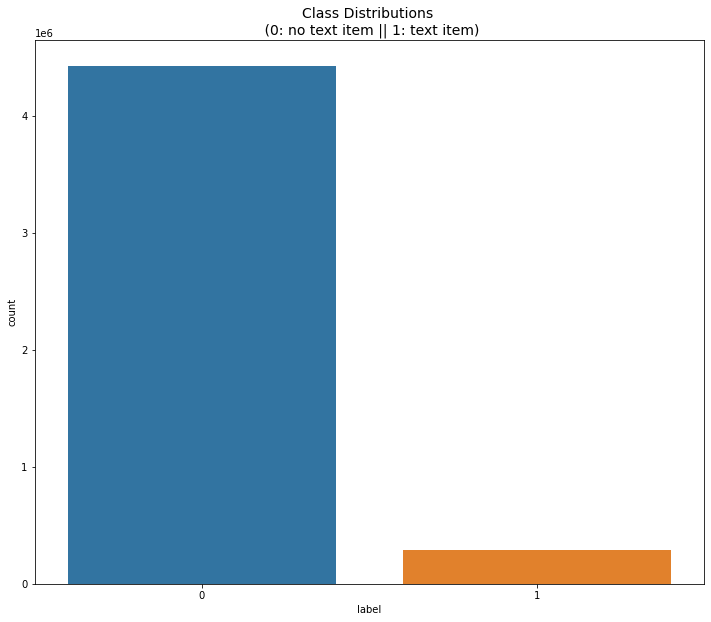

In [33]:
sns.countplot('label', data=train)
plt.title('Class Distributions \n (0: no text item || 1: text item)', fontsize=14)

### Feature engineering

In [34]:
def calculate_bbox_volumn(data: pd.DataFrame) -> pd.DataFrame:
    
    data["bbox_volumn"] = abs(data['region.width'] * data['region.height'])
    
    return data


def calculate_value_length(data: pd.DataFrame) -> pd.DataFrame:
    
    data["value_length"] = [len(i) for i in data["value"]]
    
    return data

In [35]:
train = calculate_bbox_volumn(train)
test = calculate_bbox_volumn(test)

train = calculate_value_length(train)
test = calculate_value_length(test)

In [36]:
num_columns = [ 'region.left', 'region.top', 'region.width', 'region.height', 'label', 'value_length', 'bbox_volumn', 'region.page']

Also it is bad practice, but I prefer to undersample, before I create plots. From the desciptive analysis, there is a hugh overlap between non-text items and text items. This will become more clear with plots.

In [37]:
train[train.label==0].describe(include="all", percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

,value,region.left,region.top,region.width,region.height,region.page,id,indices,label,bbox_volumn,value_length
count,4429136,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4.429136e+06,4429136.0,4.429136e+06,4.429136e+06
unique,501438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,3Q==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,64106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.469610e-01,5.419293e-01,4.525161e-02,7.777829e-03,1.103981e+00,2.715374e+08,1.357077e+02,0.0,3.858837e-04,9.529591e+00
std,NaN,2.594692e-01,2.786358e-01,3.872087e-02,3.223811e-03,4.152080e-01,1.254780e+08,1.403100e+02,0.0,5.569593e-04,6.548652e+00
min,NaN,-4.151261e-01,-4.274673e+00,0.000000e+00,-4.156770e-02,1.000000e+00,7.143602e+07,0.000000e+00,0.0,0.000000e+00,4.000000e+00
1%,NaN,4.923135e-02,5.085714e-02,2.001601e-03,1.141227e-03,1.000000e+00,7.460892e+07,1.000000e+00,0.0,3.977019e-06,4.000000e+00
5%,NaN,9.411765e-02,1.212034e-01,6.449012e-03,4.750594e-03,1.000000e+00,8.778061e+07,9.000000e+00,0.0,3.615955e-05,4.000000e+00
10%,NaN,1.176471e-01,1.701510e-01,1.008403e-02,5.050505e-03,1.000000e+00,1.086045e+08,1.800000e+01,0.0,6.601967e-05,4.000000e+00


In [38]:
train[train.label==1].describe(include="all", percentiles=[0.01, 0.05, 0.1, 0.2, 0.8, 0.9, 0.95, 0.99])

,value,region.left,region.top,region.width,region.height,region.page,id,indices,label,bbox_volumn,value_length
count,288667,288667.000000,288667.000000,288667.000000,288667.000000,288667.000000,2.886670e+05,288667.000000,288667.0,288667.000000,288667.000000
unique,68353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Xg==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.297313,0.508321,0.049002,0.008029,1.181140,2.753828e+08,156.595686,1.0,0.000413,9.914885
std,NaN,0.137272,0.132797,0.035979,0.001990,0.520034,1.243393e+08,162.404479,0.0,0.000356,6.021309
min,NaN,0.001681,0.020202,0.000000,0.000000,1.000000,7.143602e+07,0.000000,1.0,0.000000,4.000000
1%,NaN,0.061766,0.164655,0.003361,0.001188,1.000000,7.508456e+07,22.000000,1.0,0.000006,4.000000
5%,NaN,0.100403,0.305162,0.006723,0.004985,1.000000,8.850620e+07,40.000000,1.0,0.000044,4.000000
10%,NaN,0.127731,0.359857,0.010676,0.005945,1.000000,1.136816e+08,50.000000,1.0,0.000080,4.000000


## Imbalanced Data

There are several methods to deal with imbalanced data. Common, there is
- over-sampling (random, SMOTE)
- under-sampling (random, clustering)


Since training time over night is free, I played around with over- and undersampling. From my experience, undersampling was faster and provided higher F1-scores. Overall the performance is not great, but with undersampling, I got better results. So I will continue here.

A problem with random under-sampling is, that probably some important data points for the classification will be missing. Also removing data is most of the time not a good strategy.

In [39]:
text_items = train[train.label == 1]
non_text_items = train[train.label == 0]

I choose here to introduce a small bias. I want to have two times more non-text items than text items. 

In [40]:
np.random.seed(12345)
idx = np.random.choice(non_text_items.index, size=2*text_items.shape[0], replace=True, p=None)

In [41]:
sample_non_text_items = non_text_items.loc[idx]

In [42]:
assert sample_non_text_items.shape[0] == text_items.shape[0] *2

In [43]:
us_train = pd.concat([text_items, sample_non_text_items], axis=0)
us_train.reset_index(inplace=True, drop=True)

Text(0.5, 1.0, 'Class Distributions \n (0: no text item || 1: text item)')

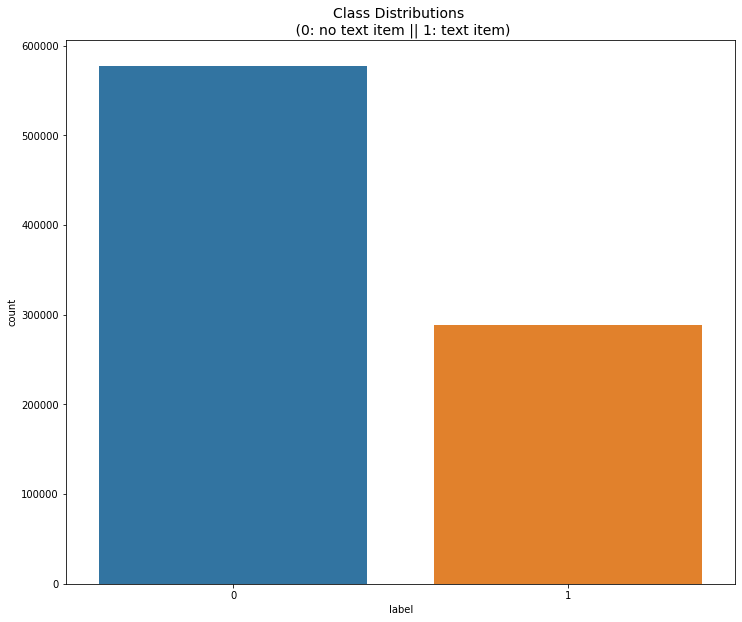

In [44]:
sns.countplot('label', data=us_train)
plt.title('Class Distributions \n (0: no text item || 1: text item)', fontsize=14)

Plotting with undersampled data is not good, but based on calculation time, I will have a look. Some information for the non-text label will be missing.

In [45]:
dist_data = pd.melt(us_train[num_columns[:-3]], id_vars=["label"])

In the pairplot is it very obvious, that the non-text items overlie the text items. Other way, the text items are found only on a specific part of the page. Mostly in the relative top-left of a page. The width and the height of the bbox doesn't show a big difference, as in the box plots below.

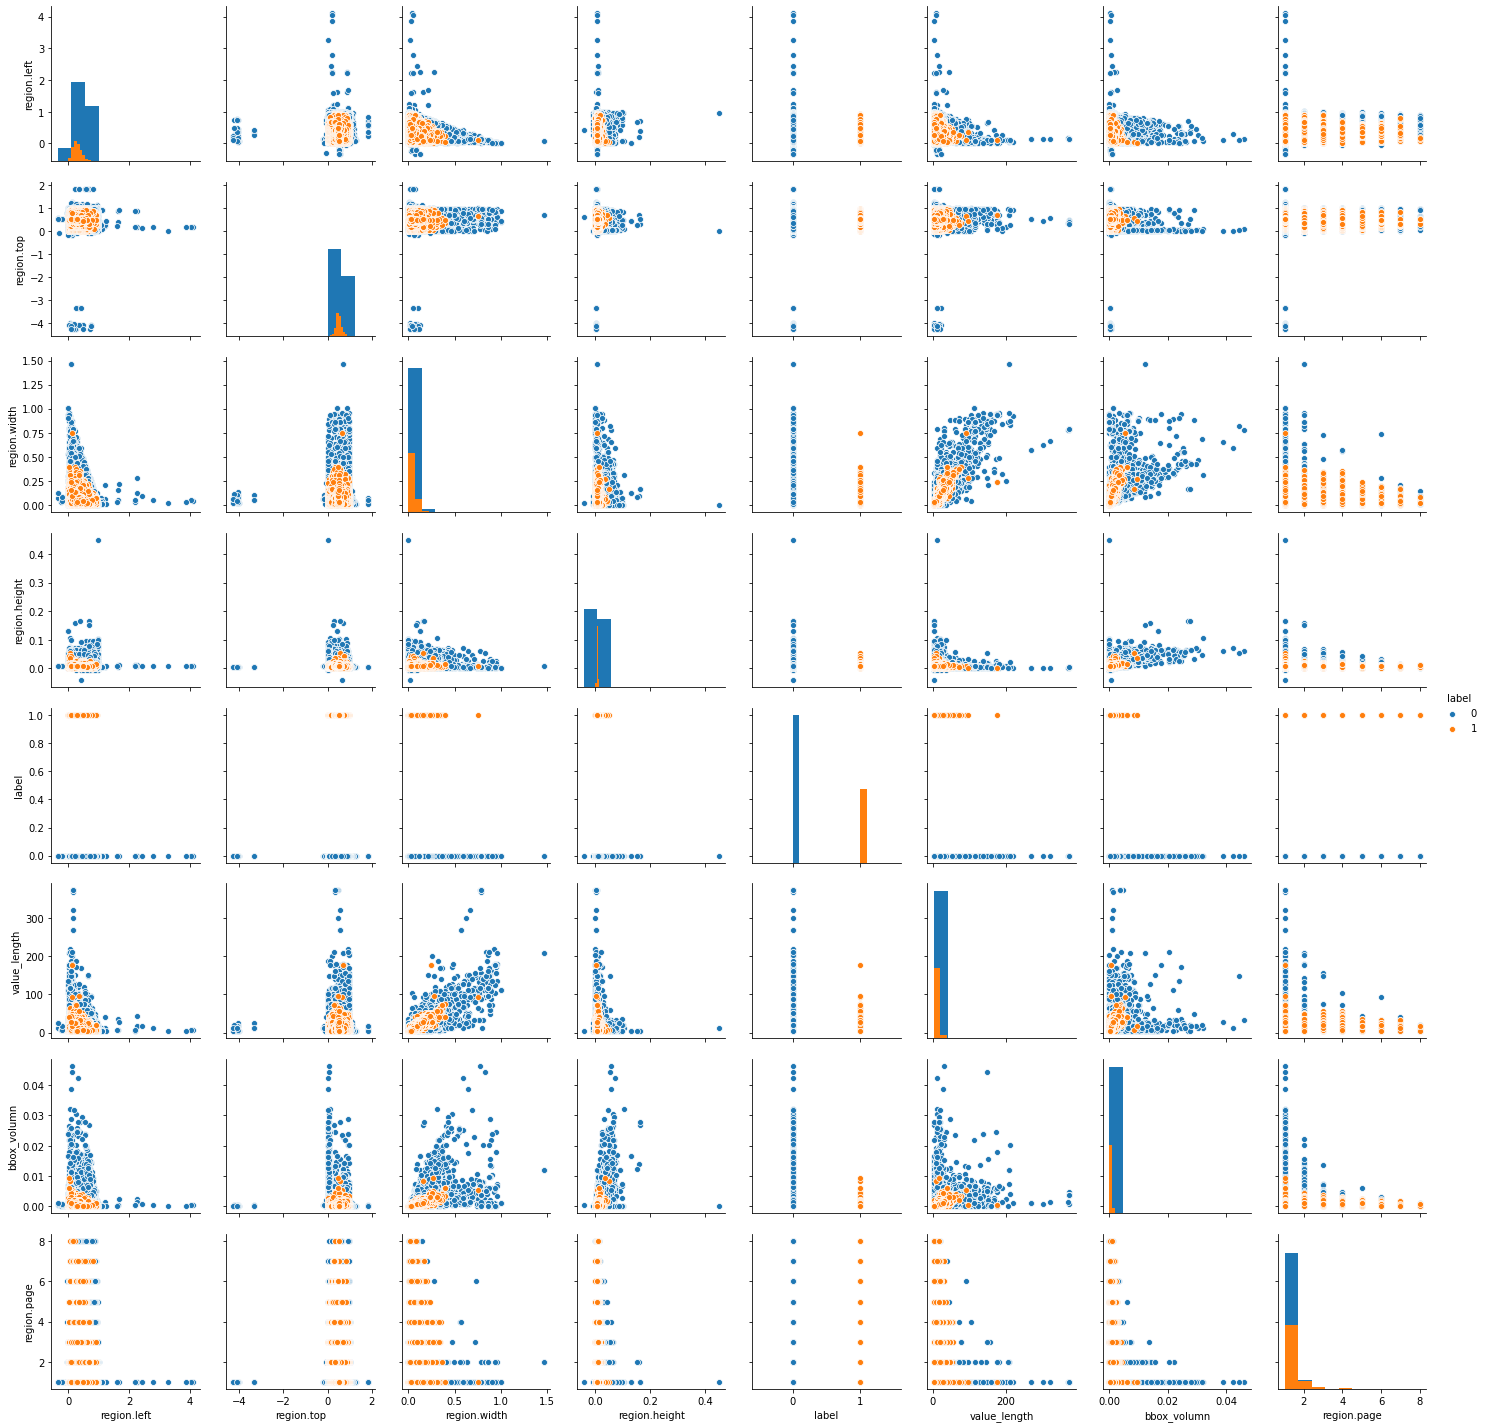

In [46]:
sns.pairplot(us_train[num_columns], height = 2.5, diag_kind='hist', hue="label")
plt.show()

plot doesn't work; needs refactoring

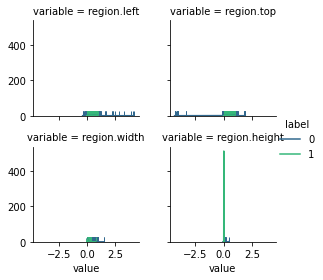

In [47]:
g = sns.FacetGrid(dist_data, col='variable', hue="label", palette="viridis", height=2, col_wrap=2)
g = (g.map(sns.distplot, "value", hist=False, rug=True, bins=50, hist_kws={'alpha': 0.5}).add_legend())

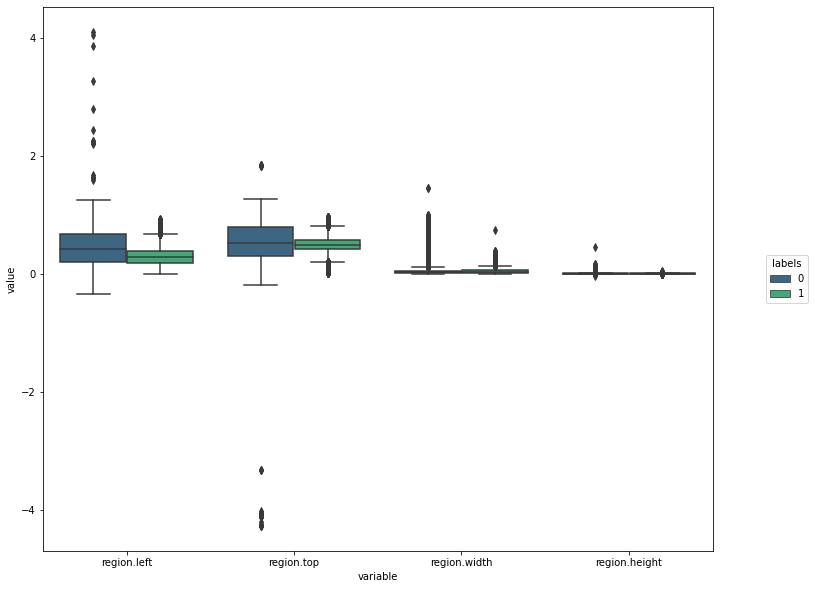

In [48]:
sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
            data=dist_data)

plt.legend(title="labels", loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)

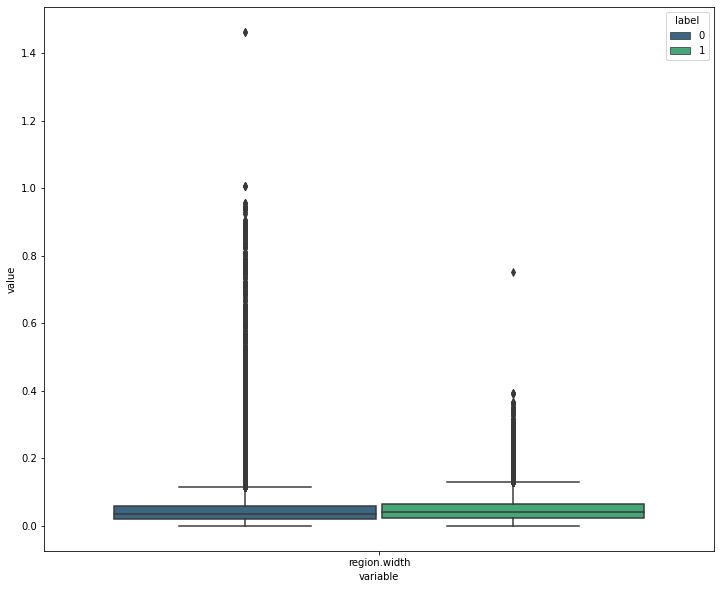

In [49]:
sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
                data=pd.melt(us_train[["region.width", "label"]], id_vars=["label"]))

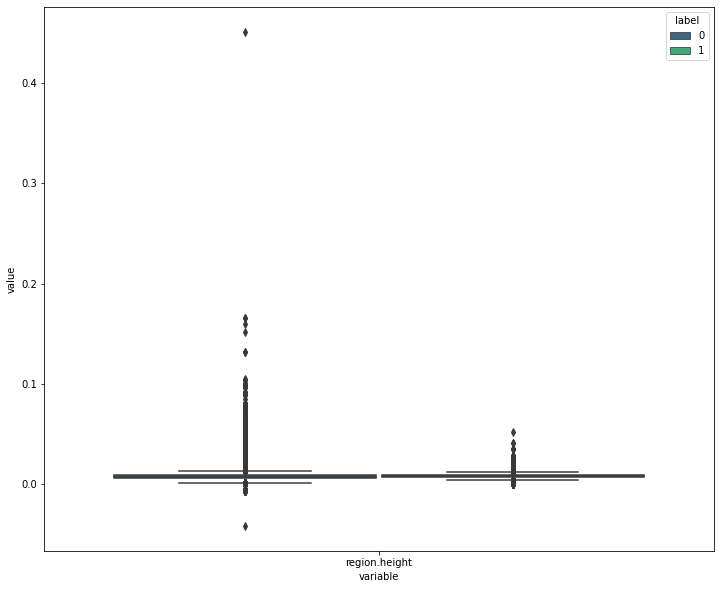

In [50]:
sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
                data=pd.melt(us_train[["region.height", "label"]], id_vars=["label"]))

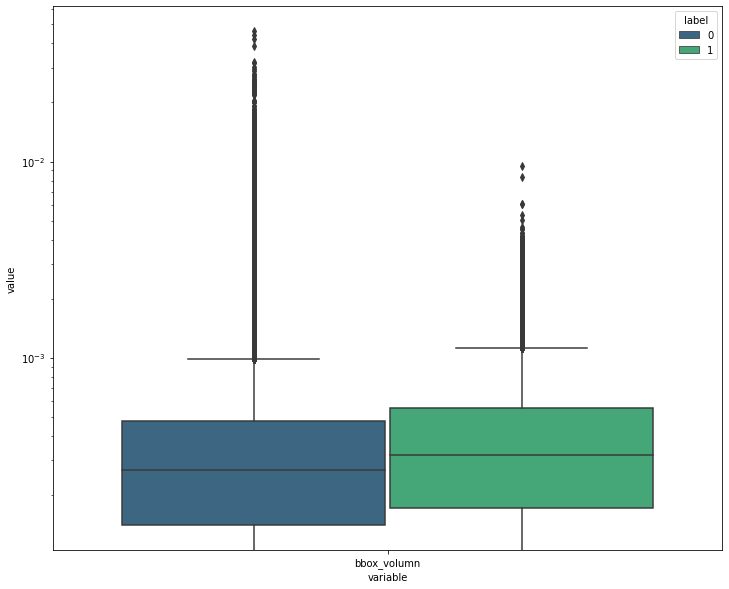

In [51]:
g = sns.boxplot(x="variable", y="value", hue='label', palette="viridis",
                data=pd.melt(us_train[["bbox_volumn", "label"]], id_vars=["label"]))
g.set_yscale("log")

The boxplots don't look very promising. The non items overlap the classified items in all relevant features. But let's have a look how trees will perform.

### Baseline

Basically, I want to train a tree with depth one, just to see, how good it will perform.

In [52]:
X_train = train[['region.left', 'region.top', 'region.width', 'region.height', 'region.page','value_length', 'bbox_volumn']]
y_train = train["label"] 

X_test = test[['region.left', 'region.top', 'region.width', 'region.height', 'region.page','value_length', 'bbox_volumn']]
y_test = test["label"] 

In [53]:
X_train_sub = us_train[['region.left', 'region.top', 'region.width', 'region.height', 'region.page','value_length', 'bbox_volumn']]
y_train_sub = us_train["label"] 

In [54]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train_sub, y_train_sub)

DecisionTreeClassifier(max_depth=1)

In [55]:
feature_names = [i for i in X_train_sub.columns]

y_train_str = y_train_sub.astype('str')
y_train_str[y_train_str == '0'] = 'no_text_item'
y_train_str[y_train_str == '1'] = 'text_item'

In [56]:
export_graphviz(tree, out_file='min_tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

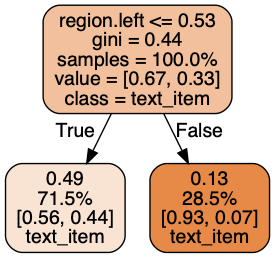

In [57]:
from subprocess import call
call(['dot', '-Tpng', 'min_tree.dot', '-o', 'min_tree.png', '-Gdpi=100'])

from IPython.display import Image
Image(filename = 'min_tree.png')

In [58]:
y_hat = [1 if i <= 0.53 else 0 for i in train['region.left']]

In [59]:
pd.DataFrame(confusion_matrix(y_train, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,1780349,17978
text_item,2648787,270689


In [60]:
f1_score(y_train, y_hat)

0.1687512059156964

In [61]:
precision_score(y_train, y_hat)

0.09271835082734024

In [62]:
recall_score(y_train, y_hat)

0.9377206261886534

With one feature, we get to a F1-Score of 0.17, which is really bad. The precision is too low. Too many non-text items are classified as text-items. Let's see, if a more sophisticated approach will help or if the data is too noisy.

In [77]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])


def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


## DecisionTree

Training of a slighty bigger decision tree. The F1-score on the undersampled train data looks okayish. Still not great, but it is an improvement. 

In [63]:
tree = DecisionTreeClassifier(random_state=0, max_depth=8, criterion='gini')

training_score = cross_val_score(tree, X_train_sub, y_train_sub, cv=5, scoring='f1')
print(f"Decision Tree has a cross_validationg F1 score of {training_score.mean():.2}")

Decision Tree has a cross_validationg F1 score of 0.69


In [64]:
tree = DecisionTreeClassifier(random_state=0, max_depth=8, criterion='gini')
tree.fit(X_train_sub, y_train_sub)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [65]:
export_graphviz(tree, out_file='tree_depth_8.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree_depth_8.dot', '-o', 'tree_depth_8.png', '-Gdpi=100'])

0

Let's see, how well the tree generalizes on the whole dataset. The F1-scores drops as expected, since we add only non-text items here. So a decision tree is not the best option, but at least a start.

In [66]:
y_hat = tree.predict(X_train)

In [67]:
pd.DataFrame(confusion_matrix(y_train, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,3712875,86700
text_item,716261,201967


In [68]:
f1_score(y_train, y_hat)

0.334688601742488

In [69]:
precision_score(y_train, y_hat)

0.2199529964235462

In [70]:
recall_score(y_train, y_hat)

0.6996539264966207

### XGBoost

The imrpovement with the decision tree looks interesting. I would try to train an XGBoost model and see how weel he generalizes. Out of time reasons, I choose more a stomp like approach with a max depth of 2. Since boosing is basicallt gradually learning, this is okay. Probably the number of trees could be better. Also there is much more space for improvement, but any hyperparameter tuning doesn't make sense, as long as the metrics are really bad.

In [148]:
# Overfitting? Based on the implementation, it is not clear!!!

# TODO: include X_val and plot error of the learning curve

In [89]:
xgb_clf = xgb.XGBClassifier(max_depth=2, n_estimators=200, objective='binary:logistic', gamma=0.1, random_state=1234, early_stopping_rounds=10)

In [90]:
y_scores = cross_val_predict(xgb_clf, X_train_sub, y_train_sub, cv=2, method="predict_proba")

In [91]:
precisions, recalls, thresholds = precision_recall_curve(y_train_sub, y_scores[:,1])

Here I calculated on the cv training the decision threshold vs precision and recall. The precision curve is a bit bumpy and slowly changes, while the recall reacts stronger to the threshold. Since I'm interested in a better precision (the model lacks here), I go for a decision threshold of 0.6.

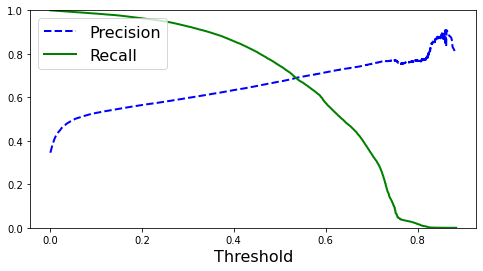

In [92]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [93]:
precisions, recalls, thresholds = precision_recall_curve(y_train_sub, y_scores[:, 1])

Precision vs recall is really low. On the sub-samled data it reaches not more than 0.8. But also, it doesnt fall very much with an increased recall.

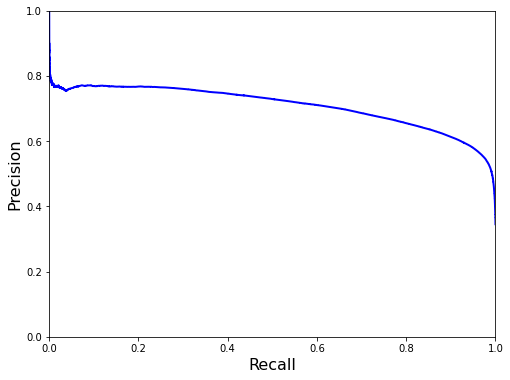

In [94]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

The ROC curve plots  the true positive rate vs false positive rate. The curve is comparable low, which means the classifier is not really good. There are too many false positives in the under-sampled dataset.

In [95]:
fpr, tpr, thresholds = roc_curve(y_train_sub, y_scores[:, 1])

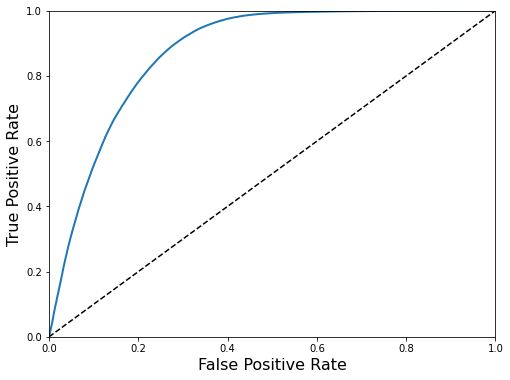

In [96]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [97]:
roc_auc_score(y_train_sub, y_scores[:,1])

0.8746504185660231

The model is not really good on the under-sampled data. I will apply it to the full training dataset (show more non-texxt items to it) and have a look at the test set.

In [98]:
xgb_clf = xgb.XGBClassifier(max_depth=2, n_estimators=200, objective='binary:logistic', gamma=0.1, random_state=1234, early_stopping_rounds=10)
xgb_clf.fit(X_train_sub, y_train_sub)

XGBClassifier(early_stopping_rounds=10, gamma=0.1, max_depth=2,
              n_estimators=200, random_state=1234)

In [99]:
y_hat_prob = xgb_clf.predict_proba(X_train)

As stated above I pick a decision threshold of 0.6

In [100]:
y_hat = [0 if i <= 0.6 else 1 for i in y_hat_prob[:,1]]

The result is bad. There are much more non text items classified as text item, than text items in the whole dataset. 

Possible problems are: noisy data, wrong model, too less features,  errors in the data preparation

In [101]:
pd.DataFrame(confusion_matrix(y_train, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,3925581,122161
text_item,503555,166506


In [102]:
f1_score(y_train, y_hat)

0.3473477357498686

In [103]:
precision_score(y_train, y_hat)

0.24849379384861975

In [104]:
recall_score(y_train, y_hat)

0.5768099574942754

And let's have a look at the test set. The F1-score is with 0.27 lower than the F1-score of the training set. This is expected. Here the same problems occur as above. The model is not suitable for this task.

In [105]:
y_hat_prob = xgb_clf.predict_proba(X_test)

In [106]:
y_hat = [0 if i <= 0.6 else 1 for i in y_hat_prob[:,1]]

In [107]:
pd.DataFrame(confusion_matrix(y_test, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,169476,4110
text_item,27789,5964


In [108]:
f1_score(y_test, y_hat)

0.2721609966459032

In [109]:
precision_score(y_test, y_hat)

0.17669540485290197

In [110]:
recall_score(y_test, y_hat)

0.5920190589636688

## Sequential classification

The idea of an LSTM or RNN seems possible, since the structure follows a sequence. I havn't applied LSTMs/RNNs in a long run, so this is a very first prototype.

In [114]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [127]:
train = train[['region.left', 'region.top', 'region.width', 'region.height', 'region.page','value_length', 'bbox_volumn', 'label']]

test = test[['region.left', 'region.top', 'region.width', 'region.height', 'region.page','value_length', 'bbox_volumn']]

In [164]:
neg, pos = sum(train['label']==0), sum(train['label']==1)
total = neg + pos

In [129]:
train_df, val_df = train_test_split(train, test_size=0.2)

y_train = np.array(train_df.pop('label'))
y_val = np.array(val_df.pop('label'))
# y_test = np.array(test.pop('label'))

This build a Sequence of the bounding boxes. I look at the bounding box before and behind the specific bounding box. So I create a sequence of 3 bboxes for the LSTM. 

In [130]:
train_df = pd.concat([train_df.shift(-1), train_df, train_df.shift(1)],axis=1)
val_df = pd.concat([val_df.shift(-1), val_df, val_df.shift(1)],axis=1)
test_df = pd.concat([test.shift(-1), test, test.shift(1)],axis=1)

In [131]:
train_df = fill_nan(train_df, 0)
val_df = fill_nan(val_df, 0)
test_df = fill_nan(test_df, 0)

In [134]:
X_train = np.array(train_df)
X_val = np.array(val_df)
X_test = np.array(test_df)

In [135]:
scaler = MinMaxScaler(feature_range = (0, 1))
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [136]:
X_train = X_train.reshape((X_train.shape[0], 3, X_train.shape[1]//3))
X_val = X_val.reshape((X_val.shape[0], 3, X_val.shape[1]//3))
X_test = X_test.reshape((X_test.shape[0], 3, X_test.shape[1]//3))

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training features shape: (3774242, 3, 7)
Validation features shape: (943561, 3, 7)
Test features shape: (207339, 3, 7)


Adding weights for the model. Positive labels get a heigher weight, which afaik will be multiplied with the gradient in the cost function.

In [141]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.17


In [142]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

In [143]:
def make_model(metrics = METRICS):
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=metrics)  

    return model

In [146]:
early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

The training takes too long; probably I should have taken only one LSTM layer and less units. Dropout layers are introduced to prevent overfitting. From my prototyping I can conclude, that the class weights improve the learning a lot. Most of my previous approaches failed, because the model was only predicting zeros.

In [147]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=20,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    verbose=1)

Train on 3774242 samples, validate on 943561 samples
Epoch 1/20
3774242/3774242 [==============================] - 380s 101us/step - loss: 0.5810 - tp: 198748.0000 - fp: 1820143.0000 - tn: 1722806.0000 - fn: 32545.0000 - accuracy: 0.5091 - precision: 0.0984 - recall: 0.8593 - auc: 0.7310 - val_loss: 0.5604 - val_tp: 48316.0000 - val_fp: 395761.0000 - val_tn: 490426.0000 - val_fn: 9058.0000 - val_accuracy: 0.5710 - val_precision: 0.1088 - val_recall: 0.8421 - val_auc: 0.7639
Epoch 2/20
3774242/3774242 [==============================] - 367s 97us/step - loss: 0.5207 - tp: 196675.0000 - fp: 1346051.0000 - tn: 2196898.0000 - fn: 34618.0000 - accuracy: 0.6342 - precision: 0.1275 - recall: 0.8503 - auc: 0.8027 - val_loss: 0.5001 - val_tp: 51712.0000 - val_fp: 267551.0000 - val_tn: 618636.0000 - val_fn: 5662.0000 - val_accuracy: 0.7104 - val_precision: 0.1620 - val_recall: 0.9013 - val_auc: 0.8659
Epoch 3/20
3774242/3774242 [==============================] - 367s 97us/step - loss: 0.4397 - tp

3774242/3774242 [==============================] - 361s 96us/step - loss: 0.4212 - tp: 208821.0000 - fp: 1039957.0000 - tn: 2502992.0000 - fn: 22472.0000 - accuracy: 0.7185 - precision: 0.1672 - recall: 0.9028 - auc: 0.8706 - val_loss: 0.4660 - val_tp: 51938.0000 - val_fp: 264244.0000 - val_tn: 621943.0000 - val_fn: 5436.0000 - val_accuracy: 0.7142 - val_precision: 0.1643 - val_recall: 0.9053 - val_auc: 0.8712


The model performs worse than the xgboost model; Interestingly in one of my prototypes, I achieved an F1-Score of 0.34 with a mugh higher precision. No idea, what went wrong, when I transformed the model to this notebook. 

The train-validation curves won't show any overfitting. The precision is still quite bad. The model predicts too many False Positives. Also the model took too long for training. One LSTM layer less and probably a few nodes less would have been better. 

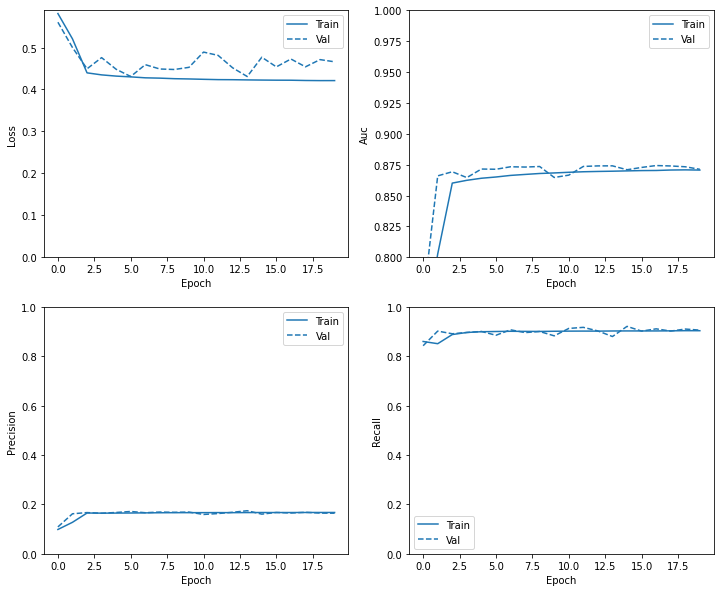

In [149]:
plot_metrics(weighted_history)

In [150]:
y_hat = weighted_model.predict_classes(X_test, batch_size=256, verbose=0)

In [151]:
pd.DataFrame(confusion_matrix(y_test, y_hat).T, columns=["no_text_item","text_item"], index=["no_text_item","text_item"])

,no_text_item,text_item
no_text_item,128227,895
text_item,69038,9179


In [152]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=256, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)


loss :  0.5457114329364016
tp :  9179.0
fp :  69038.0
tn :  128227.0
fn :  895.0
accuracy :  0.6627117991447449
precision :  0.11735300719738007
recall :  0.9111574292182922
auc :  0.8499816656112671


In [153]:
y_hat_prob = weighted_model.predict(X_test, batch_size=256)

No time for a trade-off curve, I assume 0.6 like above. Highly speculative.

In [163]:
f1_score(y_test, y_hat_prob>0.6)

0.22651634306559695

In [162]:
precision_score(y_test, y_hat_prob>0.6)

0.13065487535259587

In [161]:
recall_score(y_test, y_hat_prob>0.6)

0.8506055191582291